[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


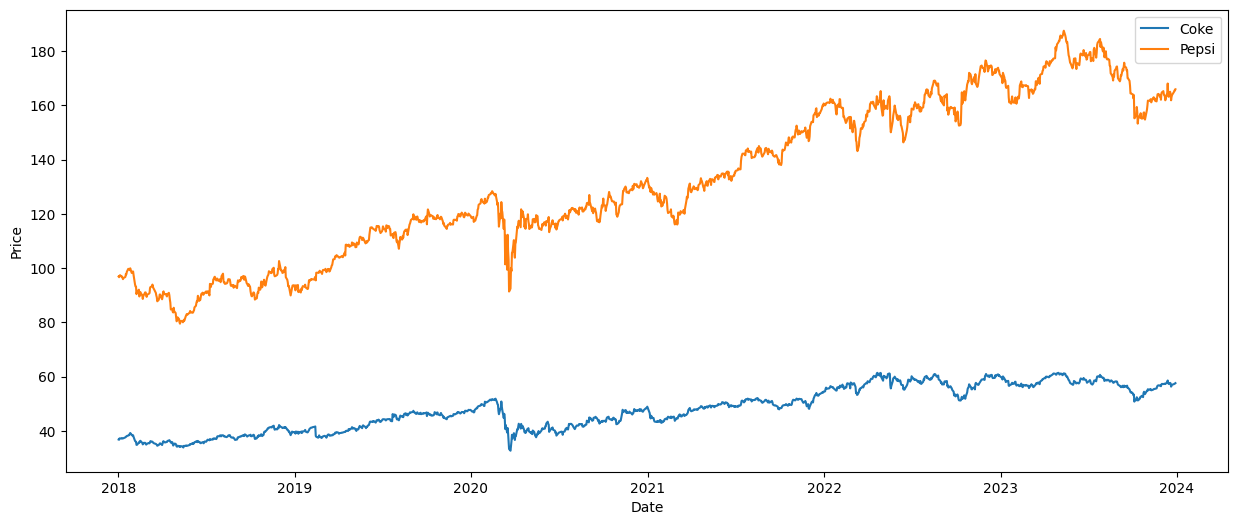

In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller


stock1 = 'KO'
stock2 = 'PEP'
startdate = '2018-01-01'
enddate = '2024-01-01'

data1 = yf.download(stock1, start=startdate, end=enddate)['Adj Close']
data1.columns=['Adj Close']
data2 = yf.download(stock2, start=startdate, end=enddate)['Adj Close']
data2.columns=['Adj Close']
prices = pd.concat([data1, data2], axis=1, keys=['KO', 'PEP'])
prices.columns=['KO Adj close','PEP Adj close']
# Plot the prices
plt.figure(figsize=(15, 6))
plt.plot(data1, label='Coke')
plt.plot(data2, label='Pepsi')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.975e+04
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:58:46   Log-Likelihood:                -5201.9
No. Observations:                1509   AIC:                         1.041e+04
Df Residuals:                    1507   BIC:                         1.042e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.2715      1.191    -27.932      0.0

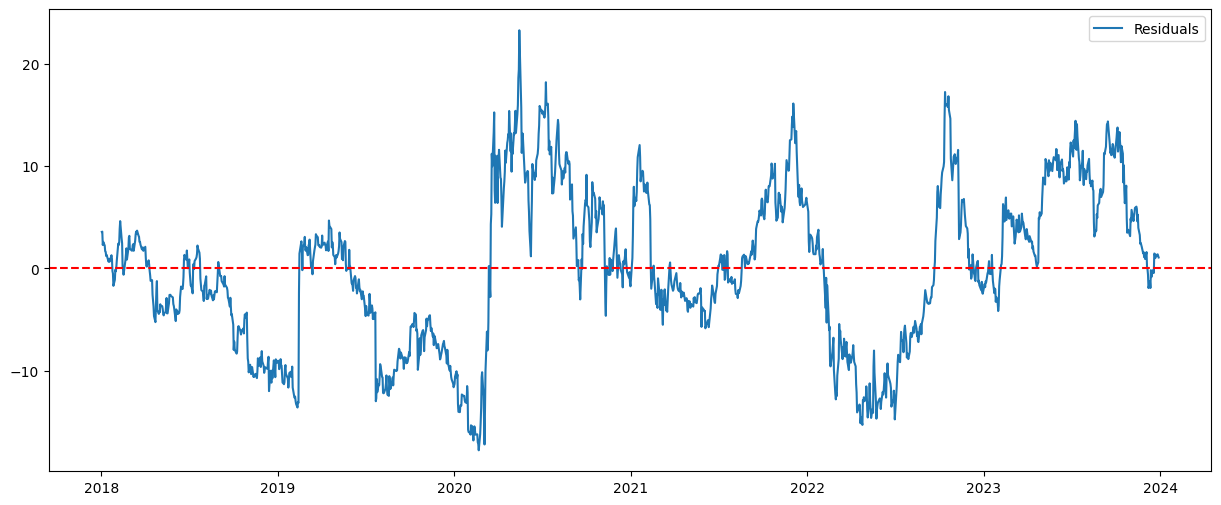

In [77]:
# Engle granger step 1: Perform OLS Regression to Find the Long-Run Relationship

x=sm.add_constant(data1) # add the constant to the independent variable 
model=sm.OLS(data2,x).fit() #Regression of pep on ko
print(model.summary()) # Display the summary

prices['Residuals']=model.resid

plt.figure(figsize=(15,6))
plt.plot(prices['Residuals'],label='Residuals')
plt.legend()
plt.axhline(y=0, color='red', linestyle='--')

In [78]:

# Engle granger step 2: Augmented Dickey-Fuller (ADF) Test on Residuals
result=adfuller(prices['Residuals'])
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')
    
# Interpretation
if result[1] < 0.05: # I have chaged the limit from 0.05 to 0.15  so that i can procede.
    print("The residuals are stationary. Pepsi and Coca-Cola are cointegrated.")
else:
    print("The residuals are not stationary. Pepsi and Coca-Cola are not cointegrated.")

(np.float64(-3.225508133915336), np.float64(0.018554839641662046), 12, 1496, {'1%': np.float64(-3.4347287139577753), '5%': np.float64(-2.8634739225299133), '10%': np.float64(-2.5677995973755325)}, np.float64(5028.800893501469))
ADF Statistic: -3.225508
p-value: 0.018555
Critical Values:
	1%: -3.4347287139577753
	5%: -2.8634739225299133
	10%: -2.5677995973755325
The residuals are stationary. Pepsi and Coca-Cola are cointegrated.


In [79]:
# Step 1 and 2 combined: Test for Cointegration short cut for Engle granger test.
score, pvalue, _ = coint(data1, data2)
print(f'Cointegration test p-value: {pvalue}')
if pvalue < 0.05: 
    print("The pair is cointegrated and suitable for pairs trading.")
else:
    print("The pair is not cointegrated and may not be suitable for pairs trading.")

# Step 2: Check Correlation
correlation = prices.corr().iloc[0, 1]
print(f'Correlation: {correlation}')

Cointegration test p-value: 0.04158328195122669
The pair is cointegrated and suitable for pairs trading.
Correlation: 0.9639097174278523


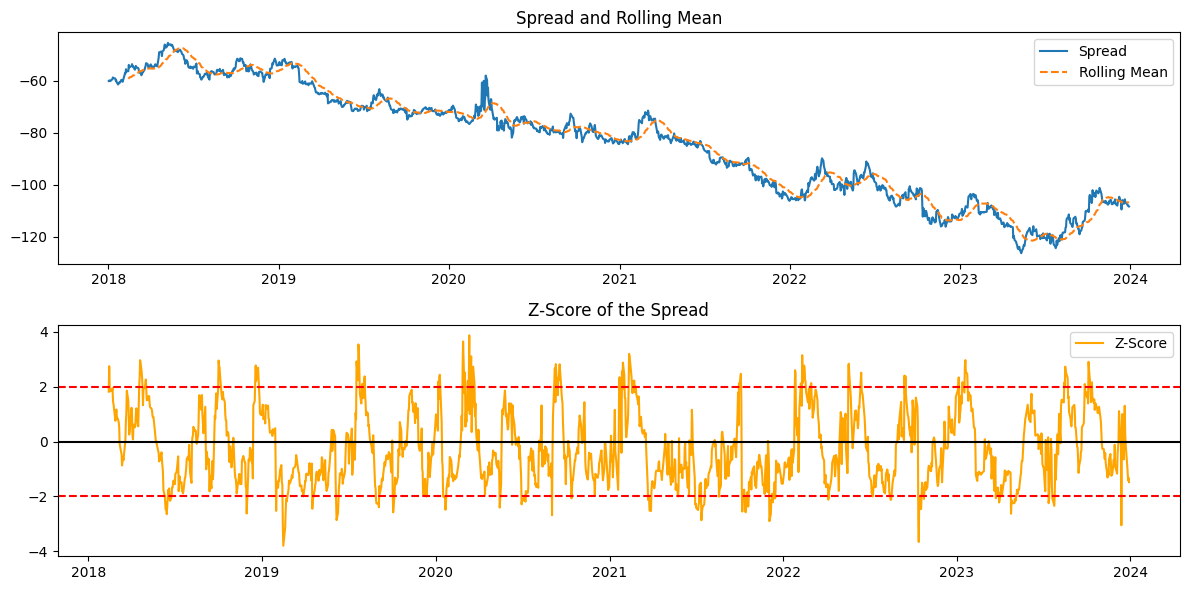

In [84]:
# Step 4: Strategy Development - Calculate Spread and Z-Score
prices['Spread'] = prices['KO Adj close'].values - prices['PEP Adj close'].values #coke - pepsi

# Calculate the rolling mean and standard deviation of the spread
window = 30
prices['Rolling Mean'] = prices['Spread'].rolling(window=window).mean()
prices['Rolling Std'] = prices['Spread'].rolling(window=window).std()

# Calculate the z-score of the spread
prices['Z-Score'] = (prices['Spread'] - prices['Rolling Mean']) / prices['Rolling Std']

# Plot the spread and z-score
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(prices['Spread'], label='Spread')
plt.plot(prices['Rolling Mean'], label='Rolling Mean', linestyle='--')
plt.title('Spread and Rolling Mean')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(prices['Z-Score'], label='Z-Score', color='orange')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
plt.title('Z-Score of the Spread')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_5455/962977172.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  prices['Short'].iloc[i] = 1
/tmp/ipykernel_5455/962977172.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

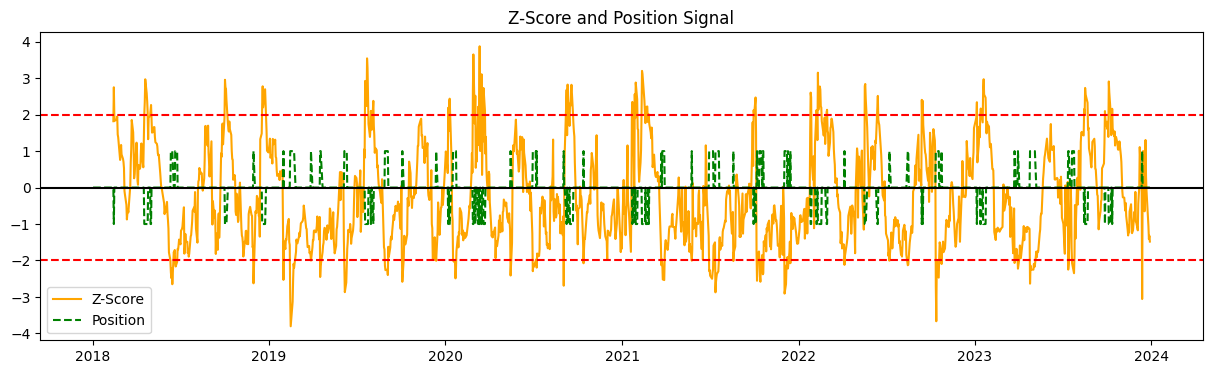

In [86]:
# Step 5: Implement the Pairs Trading Strategy Logic
entry_z_score = 2
exit_z_score = 0

# Initialize positions and signals
prices['Long'] = 0
prices['Short'] = 0
prices['Position'] = 0

# Generate trading signals
for i in range(len(prices)):
    if prices['Z-Score'].iloc[i] > entry_z_score:
        prices['Short'].iloc[i] = 1
        prices['Position'].iloc[i] = -1  # Short the spread (sell KO, buy PEP)
    elif prices['Z-Score'].iloc[i] < -entry_z_score:
        prices['Long'].iloc[i] = 1
        prices['Position'].iloc[i] = 1   # Long the spread (buy KO, sell PEP)
    elif abs(prices['Z-Score'].iloc[i]) < exit_z_score:
        prices['Position'].iloc[i] = 0   # Exit the position

# Plot positions
plt.figure(figsize=(15, 4))
plt.plot(prices['Z-Score'], label='Z-Score', color='orange')
plt.plot(prices['Position'], label='Position', color='green', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
plt.title('Z-Score and Position Signal')
plt.legend()
plt.show()

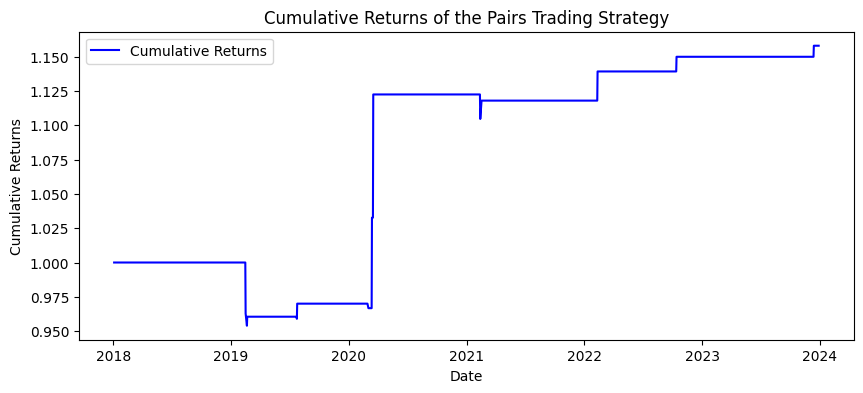

Total Returns: 15.795474887925964%
Sharpe Ratio: 4.062819726089744


In [126]:
# Step 6: Backtesting the Strategy

prices['Returns'] = prices['KO Adj close'].pct_change() - prices['PEP Adj close'].pct_change()

# Calculate strategy returns
prices['Strategy Returns'] = prices['Position'].shift(1) * prices['Returns']

# Calculate cumulative returns
prices['Cumulative Returns'] = (1 + prices['Strategy Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 4))
plt.plot(prices['Cumulative Returns'], label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns of the Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Calculate performance metrics

fil=(prices['Long']==1) | (prices['Short']==1)
num=len(prices[fil])
sharpe_ratio = ((prices['Strategy Returns'].sum()/num))/prices['Strategy Returns'].std() * np.sqrt(252)
total_returns = prices['Cumulative Returns'].iloc[-1] - 1 

print(f'Total Returns: {total_returns * 100}%')
print(f'Sharpe Ratio: {sharpe_ratio}') 